# Import Libraries

In [1]:
#export
#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################

%matplotlib notebook
import matplotlib.pyplot as plt
# import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('v2.0')

from matplotlib.font_manager import FontProperties
import seaborn as sns; sns.set()
from itertools import combinations, combinations_with_replacement
from functools import partial
from impala.dbapi import connect
from impala.util import as_pandas

import tpm
import swifter

import calendar
import pandas as pd
import numpy as np
pd.set_option("display.max_columns",999)

import gc
import os

import sqlalchemy
from sqlalchemy import create_engine

import logging

# Setting up variables, functions & Log file

In [2]:
#export
WasThereAnError = False
LogFileName = 'CrossSelling.log'
logging.basicConfig(filename=LogFileName, level=logging.DEBUG,
                    filemode='w', datefmt='%d-%b-%y %H:%M:%S',
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3]:
#export
Today = pd.to_datetime(pd.Timestamp.today().date()) # So starts today at 00:00:00
TodayString = Today.strftime('%Y-%m-%d')
Yesterday = Today-pd.Timedelta(1,unit='D')
YesterdayString = Yesterday.strftime('%Y-%m-%d')
vorEinemJahr = Today-pd.Timedelta(365,unit='D')
vorEinemJahrString = vorEinemJahr.strftime('%Y-%m-%d')

In [4]:
TodayString, YesterdayString, vorEinemJahrString

('2019-11-22', '2019-11-21', '2018-11-22')

In [5]:
def removeEmptySpaces(feld):
    try:
        return feld.split()[0]
    except:
        pass

# def removeEmptySpaces(df):
#     try:
#         return feld.split()[0]
#     except:
#         pass
    
def convertDate(feld):
    try: 
        pd.to_datetime(feld, format='%Y%m%d',errors='coerce')
    except:
        pass
    
def convertGebDatum(x):
    try:
        return pd.to_datetime(x, format='%Y%m%d')
    except:
        return pd.NaT
    
def padToLength(length, feld):
    return f'{format(feld, "0"+str(length))}'

padTo3 = partial(padToLength,3)
padTo9 = partial(padToLength,9)

# Get data from Hadoop Cluster

In [8]:
def query_cluster(query: str):
    host = "hadoop.server.de"
    port = 12345
    cursor = connect(host=host, port=port, database="auftragsdaten").cursor()
    cursor.execute(query)
    return as_pandas(cursor)


In [9]:
query = f'''
select bare.firma,  
    bare.land,  
    bare.konto_nummer,  
    bare.custom_id,  
    bare.auftrags_identifikation, 
    bare.varianten_nummer, 
    bare.varianten_groesse, 
    bare.artikel_nummer, 
    bare.bestell_stueckzahl, 
    bare.bestell_vk, 
    bare.bestell_netto_vek, 
    bare.mwst_satz, 
    bare.bestell_preis_nachlass, 
    bare.waren_gruppe, 
    bare.sgf, 
    bare.auftrags_weg, 
    bare.datum_auftrag, 
    bare.zeitpunkt_auftrag, 
    bare.vorgangs_art, 
    bare.aufloesungs_art, 
    bare.datum_erledigung, 
    bare.datum_retoure, 
    bare.grund_retoure, q
    bare.retoure_stueckzahl, 
    bare.anzahl_retouren_events, 
    bare.werbemittel_art, 
    bare.id_order,
    bare.sessionid,
    bare.visitorid,
    bare.werbemittel_nummer,
    kuba.anrede, kuba.sprache, kuba.anrede, kuba.datum_adress_anlage_all, kuba.datum_letzte_aenderung_all, kuba.geburts_datum, kuba.plz,
    beg.aktions_nr, beg.orig_aktions_nummer,
    akka.kanal
from default_kudu.basic_returns as bare 
left join
default_kudu.kunde_basis_v2_20120128 as kuba
on bare.custom_id=kuba.customer_id
and bare.land=kuba.land
left join
default.bestag_g_v4_20160907 as beg
on bare.auftrags_identifikation=beg.auftrags_identifikation
left join
flavio_knm.aktnr_kanal_mapping as akka
on  beg.aktions_nr = akka.rd_name
where bare.datum_auftrag > '{vorEinemJahrString}' and 
bare.firma= 'xxx'
'''

In [ ]:
data_raw = query_cluster(query) # returns pandas dataframe

### To / From pickle

In [ ]:
# data_raw.to_pickle('data_raw_klingel_1Jahr.pickle')

In [6]:
# data_raw = pd.read_pickle('data_daw_wenz_1Jahr.pickle')

### Cleaning the dates
**not geburts_datum** for which I get an unintelligible error message

In [7]:
data_raw.datum_auftrag = pd.to_datetime(data_raw.datum_auftrag, format='%Y-%m-%d', errors='coerce')
data_raw.zeitpunkt_auftrag = pd.to_datetime(data_raw.zeitpunkt_auftrag, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
data_raw.datum_erledigung = pd.to_datetime(data_raw.datum_erledigung, format='%Y-%m-%d', errors='coerce')
data_raw.datum_retoure = pd.to_datetime(data_raw.datum_retoure, format='%Y-%m-%d', errors='coerce')
data_raw.datum_adress_anlage_all = pd.to_datetime(data_raw.datum_adress_anlage_all, format='%Y%m%d', errors='coerce')
data_raw.datum_letzte_aenderung_all = pd.to_datetime(data_raw.datum_letzte_aenderung_all, format='%Y%m%d', errors='coerce')

In [8]:
data_raw.dtypes

firma                                 object
land                                  object
konto_nummer                          object
custom_id                             object
auftrags_identifikation               object
varianten_nummer                      object
varianten_groesse                     object
artikel_nummer                        object
bestell_stueckzahl                     int64
bestell_vk                           float64
bestell_netto_vek                    float64
mwst_satz                            float64
bestell_preis_nachlass                 int64
waren_gruppe                          object
sgf                                   object
auftrags_weg                          object
datum_auftrag                 datetime64[ns]
zeitpunkt_auftrag             datetime64[ns]
vorgangs_art                          object
aufloesungs_art                       object
datum_erledigung              datetime64[ns]
datum_retoure                 datetime64[ns]
grund_reto

### Removing retoure

In [9]:
# There is a couple of entries where **retoure_stueckzahl** > **bestell_stueckzahl** !!
# I remove also entries where **retoure_stueckzahl** == **bestell_stueckzahl**
data = data_raw.loc[data_raw.bestell_stueckzahl>data_raw.retoure_stueckzahl,:].copy()

# # Removing by hand the remaining contribution of the retoured objects
# # Considering only the lines where there are still retoure_stueckzahl>0, i.e. where people have done only partial retoure
# # of some articles
# # NB here I don't remove the lines but only remove the contribution of the retoured articles to the total bestell_vk
data.loc[data.retoure_stueckzahl>0,'bestell_vk'] = data.loc[data.retoure_stueckzahl>0,'bestell_vk']*(1-data.loc[data.retoure_stueckzahl>0,'retoure_stueckzahl']/data.loc[data.retoure_stueckzahl>0,'bestell_stueckzahl'])


In [10]:
data_raw.shape, data.shape

((2957839, 37), (1828988, 37))

### How much time between first day in DB and day of shopping
**If zero** then this is a NEUKUNDE

In [11]:
data.loc[:,'TageDelta'] = np.floor((data.loc[:,'zeitpunkt_auftrag']-data.loc[:,'datum_adress_anlage_all']) / np.timedelta64(1, 'D'))

In [15]:
Kunden_KidZeitTagedelta = data.groupby(['custom_id','datum_auftrag'])['TageDelta'].aggregate(lambda x: list(set(x))[0]).reset_index()
Kunden_KidZeitSgfTagedelta = data.groupby(['custom_id','datum_auftrag','sgf'])['TageDelta'].aggregate(lambda x: list(set(x))[0]).reset_index()

In [16]:
Kunden_KidZeitTagedelta.head(40)

,custom_id,datum_auftrag,TageDelta
0,000000056,2019-01-30,12455.0
1,000000136,2019-08-27,NaN
2,000001016,2019-01-17,12442.0
3,000001718,2019-01-11,12071.0
4,000001718,2019-05-15,12195.0
5,000001718,2019-10-11,12344.0
6,000001718,2019-10-21,12354.0
7,000002599,2019-02-20,12842.0
8,000002599,2019-06-05,12947.0
9,000002599,2019-08-07,13010.0


### Add the column "WhichBuy"

In [17]:
def AppendWBLabel(df):
    DictOfIndexList = df.custom_id.groupby((df.custom_id != df.custom_id.shift()).cumsum()).groups
#     {1: Int64Index([0, 1, 2, 3, 4], dtype='int64'),
#      2: Int64Index([5, 6], dtype='int64'),
#      3: Int64Index([7], dtype='int64'),
#      4: Int64Index([8, 9], dtype='int64')}
    ArrayOfArray = [np.arange(len(DictOfIndexList[elem])) for elem in DictOfIndexList] 
#     [array([0, 1, 2, 3, 4]),
#      array([0, 1]),
#      array([0]),
#      array([0, 1])]
    PlainArray = [j for i in ArrayOfArray for j in i]
#     [0, 1, 2, 3, 4, 0, 1, 0, 0, 1]
    return pd.concat([df,pd.Series(PlainArray,name='WhichBuy')],axis=1)

In [18]:
Kunden_KidZeitTagedelta = AppendWBLabel(Kunden_KidZeitTagedelta)

################################################################
# Remove the TageDelta<0.0
# these are usually clients that are since long time
# in the database (checked today 7.9.18 in impala)
# so it is correct to remove them (btw they should have been removed by taking the min of aufnamedatum)
#
# The values with TageDelta >> 0.0 even though WhichBuy is 0 
# (like the kunden_nummer 503073479 or 544542285) are people with aufnahmedatum in the correct period
# but for which there is no corresponding datum_auftrag. They probably completely returned the
# first buy: the auftragsdatum remains the same of the date of the first buy even though
# I completely removed the first buy

#################################################################
Kontenmit_NegTageDelta = Kunden_KidZeitTagedelta.loc[Kunden_KidZeitTagedelta.TageDelta<0.0,'custom_id'].unique()
Kunden_KidZeitTagedelta = Kunden_KidZeitTagedelta.loc[~Kunden_KidZeitTagedelta.custom_id.isin(Kontenmit_NegTageDelta)]

In [19]:
Kunden_KidZeitTagedelta.head(10)

,custom_id,datum_auftrag,TageDelta,WhichBuy
0,000000056,2019-01-30,12455.0,0
1,000000136,2019-08-27,NaN,0
2,000001016,2019-01-17,12442.0,0
3,000001718,2019-01-11,12071.0,0
4,000001718,2019-05-15,12195.0,1
5,000001718,2019-10-11,12344.0,2
6,000001718,2019-10-21,12354.0,3
7,000002599,2019-02-20,12842.0,0
8,000002599,2019-06-05,12947.0,1
9,000002599,2019-08-07,13010.0,2


In [20]:
result = pd.merge(Kunden_KidZeitTagedelta,Kunden_KidZeitSgfTagedelta,
                  on=['custom_id','datum_auftrag'],
                 how='right')

In [22]:
result.head(10)

,custom_id,datum_auftrag,TageDelta_x,WhichBuy,sgf,TageDelta_y
0,000000056,2019-01-30,12455.0,0.0,007,12455.0
1,000000136,2019-08-27,NaN,0.0,007,NaN
2,000001016,2019-01-17,12442.0,0.0,001,12442.0
3,000001016,2019-01-17,12442.0,0.0,011,12442.0
4,000001718,2019-01-11,12071.0,0.0,003,12071.0
5,000001718,2019-01-11,12071.0,0.0,011,12071.0
6,000001718,2019-05-15,12195.0,1.0,001,12195.0
7,000001718,2019-05-15,12195.0,1.0,006,12195.0
8,000001718,2019-10-11,12344.0,2.0,001,12344.0
9,000001718,2019-10-11,12344.0,2.0,011,12344.0


### Calculate the cross selling

Let's look at the following situation:

| custom_id | WhichBuy | sgf |
| --- | --- | --- |
| 123 | 1 | 12 |
| 123 | 1 | 13 |
| 123 | 2 | 13 |
| 123 | 2 | 14 |
| 124 | 1 | 13 |
| 124 | 2 | 14 |
| 125 | 1 | 12 |
| 125 | 2 | 13 |
| 125 | 2 | 14 |

this will result in the  
customer 123  
12 --> 13 (1st + 3rd lines)  
12 --> 14 (1st + 4th lines)  
13 --> 13 (2nd + 3rd lines)  
13 --> 14 (2nd + 4th lines)  

|    | 12 | 13 | 14 |
| --- | --- | --- | --- |
| 12 |  0 |  1 |  1 |
| 13 |  0 |  1 |  1 |
| 14 |  0 |  0 |  0 |

We can consider the results from the  
customer 124  
13 --> 14 (5th + 6th lines)  

|    | 12 | 13 | 14 |
| --- | --- | --- | --- |
| 12 |  0 |  0 |  0 |
| 13 |  0 |  0 |  1 |
| 14 |  0 |  0 |  0 |

We should now sum up the matrices  

|    | 12 | 13 | 14 |
| --- | --- | --- | --- |
| 12 |  0 |  1 |  1 |
| 13 |  0 |  1 |  2 |
| 14 |  0 |  0 |  0 |

Etc.

The key point is that for each customer and pair of `WhichBuy` (1-->2 or nth-->(n+1)th) we need all the possible combinations of `sgf`.  
This can be computationally effective is we use pd.merge()


In [80]:
def sumUpCrossTables(df, howManyTablesToSumUp=10):
    crossSelling = []
    howManyTables = howManyTablesToSumUp
    for i in range(howManyTables):
        temp = (df[df['WhichBuy']==i].merge(df[df['WhichBuy']==i+1], how='inner', on=['custom_id'])
                    .loc[:,['custom_id', 'WhichBuy_x', 'sgf_x', 'WhichBuy_y', 'sgf_y']])
        crossSelling.append(temp)

    crossTables = pd.crosstab(crossSelling[0]["sgf_x"], crossSelling[0]["sgf_y"], rownames=['Erste'], colnames=['Zweite'])
    for i in range(1,howManyTables):
        tempCross = pd.crosstab(crossSelling[i]["sgf_x"], crossSelling[i]["sgf_y"], rownames=['Erste'], colnames=['Zweite'])
        crossTables = crossTables.add(tempCross, fill_value=0)
    
    return crossTables



In [81]:
crossTables = sumUpCrossTables(result)
crossTables

Zweite,001,002,003,004,005,006,007,008,009,010,011,012,013,015,016,017,018,019,099
Erste,,,,,,,,,,,,,,,,,,,
001,9086.0,7417.0,4682.0,2090.0,3489.0,3258.0,18103.0,61.0,9.0,803.0,15134.0,1335.0,8199.0,129.0,7.0,30.0,2.0,269.0,40.0
002,7514.0,21052.0,7454.0,3120.0,4900.0,6382.0,31281.0,53.0,19.0,1186.0,28245.0,2105.0,13410.0,243.0,15.0,72.0,5.0,378.0,77.0
003,4143.0,7112.0,7573.0,1688.0,2444.0,2907.0,18142.0,68.0,11.0,815.0,14640.0,1146.0,7320.0,142.0,4.0,18.0,3.0,182.0,17.0
004,1841.0,2537.0,1560.0,2896.0,1354.0,1139.0,5662.0,18.0,4.0,276.0,5103.0,500.0,2580.0,45.0,8.0,6.0,1.0,109.0,15.0
005,2867.0,4325.0,2335.0,1280.0,6720.0,2516.0,8813.0,9.0,12.0,414.0,9074.0,1092.0,3655.0,85.0,3.0,14.0,2.0,517.0,21.0
006,3298.0,6449.0,3224.0,1355.0,2916.0,10752.0,13503.0,40.0,10.0,537.0,14939.0,1285.0,5340.0,157.0,4.0,20.0,5.0,277.0,201.0
007,18646.0,32555.0,20314.0,7260.0,10436.0,13448.0,107102.0,171.0,36.0,3518.0,72204.0,4400.0,40745.0,671.0,23.0,126.0,13.0,732.0,167.0
008,68.0,63.0,80.0,11.0,16.0,31.0,159.0,94.0,0.0,17.0,90.0,0.0,98.0,3.0,0.0,0.0,0.0,3.0,0.0
009,7.0,19.0,9.0,5.0,9.0,12.0,52.0,0.0,1.0,2.0,47.0,1.0,21.0,0.0,0.0,0.0,0.0,2.0,1.0


<IPython.core.display.Javascript object>


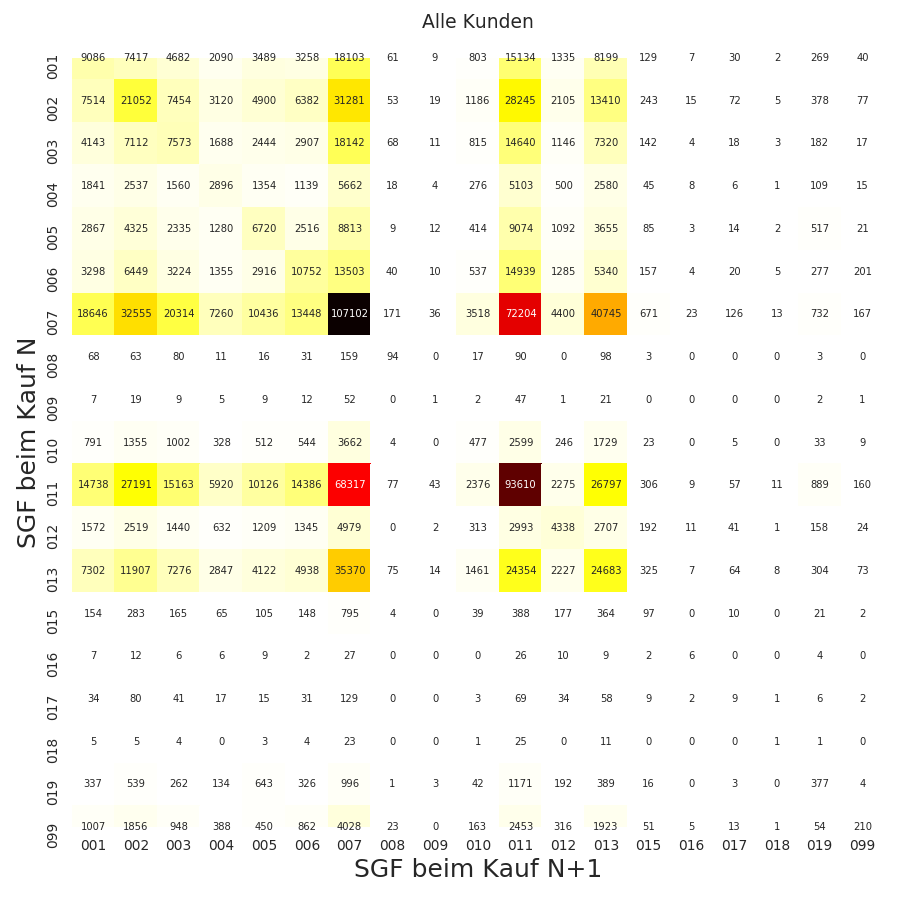

In [111]:
plt.figure(figsize=(10,10))
sns.heatmap(crossTables, annot=True, fmt=".0f",annot_kws={"size": 8},cbar=False,cmap="hot_r")
# plt.xticks(np.arange(len(WG)), Names, rotation=80)
# plt.yticks(np.arange(len(WG)), Names, rotation=30)
plt.title('Alle Kunden\n',size=15)
plt.xlabel('SGF beim Kauf N+1',fontsize=20)
plt.ylabel('SGF beim Kauf N',fontsize=20)
plt.tight_layout()
# plt.savefig('BunteBilder/'+BU+'/ErsterKaufVerhalten_Events.png')
plt.show()

### How do behave `Neukunden`? Cross selling

In [64]:
result.head(10)

,custom_id,datum_auftrag,TageDelta_x,WhichBuy,sgf,TageDelta_y
0,000000056,2019-01-30,12455.0,0.0,007,12455.0
1,000000136,2019-08-27,NaN,0.0,007,NaN
2,000001016,2019-01-17,12442.0,0.0,001,12442.0
3,000001016,2019-01-17,12442.0,0.0,011,12442.0
4,000001718,2019-01-11,12071.0,0.0,003,12071.0
5,000001718,2019-01-11,12071.0,0.0,011,12071.0
6,000001718,2019-05-15,12195.0,1.0,001,12195.0
7,000001718,2019-05-15,12195.0,1.0,006,12195.0
8,000001718,2019-10-11,12344.0,2.0,001,12344.0
9,000001718,2019-10-11,12344.0,2.0,011,12344.0


In [69]:
# CID of Neukunden
Neukunden_CID = result.loc[(result.TageDelta_x<7) & (result.WhichBuy==0),'custom_id'].unique()
# The DataFrame containing only Neukunden
resultNK = result.loc[result.custom_id.isin(Neukunden_CID),:]

In [84]:
crossTablesNK = sumUpCrossTables(resultNK,1)
crossTablesNK

Zweite,001,002,003,004,005,006,007,008,010,011,012,013,015,016,017,019,099
Erste,,,,,,,,,,,,,,,,,
001,46,14,10,4,10,2,29,0,1,12,4,15,1,0,0,1,2
002,19,83,7,12,5,11,57,0,3,33,8,41,1,0,1,5,3
003,9,14,14,5,2,5,32,0,1,20,3,17,1,0,0,0,0
004,5,8,0,28,4,3,7,0,1,8,2,5,1,0,0,2,1
005,7,7,2,5,54,6,10,0,0,5,2,8,1,0,0,2,0
006,6,14,4,7,4,86,31,0,0,27,4,7,1,0,0,1,5
007,38,75,42,15,11,24,263,0,8,97,9,84,2,0,1,3,6
008,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,0,0
010,2,2,2,0,1,0,7,0,5,5,2,8,0,0,0,0,1


<IPython.core.display.Javascript object>


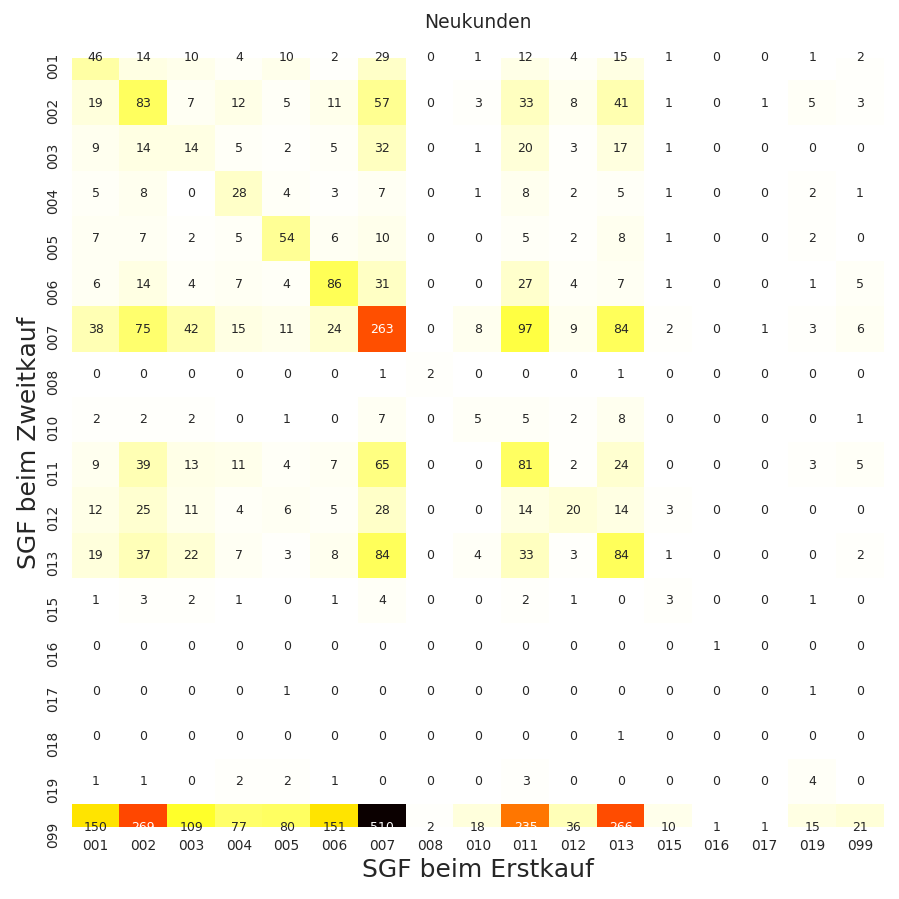

In [108]:
plt.figure(figsize=(10,10))
sns.heatmap(crossTablesNK, annot=True, fmt=".0f",annot_kws={"size": 10},cbar=False,cmap="hot_r")
# plt.xticks(np.arange(len(WG)), Names, rotation=80)
# plt.yticks(np.arange(len(WG)), Names, rotation=30)
plt.title('Neukunden\n',size=15)
plt.xlabel('SGF beim Erstkauf',fontsize=20)
plt.ylabel('SGF beim Zweitkauf',fontsize=20)
plt.tight_layout()
# plt.savefig('BunteBilder/'+BU+'/ErsterKaufVerhalten_Events.png')
plt.show()

### When is a `Neukunde` going to buy again?

In [90]:
Primo = resultNK[resultNK.WhichBuy==0]
Secondo = resultNK[resultNK.WhichBuy==1]
Terzo = resultNK[resultNK.WhichBuy==2]
Quarto = resultNK[resultNK.WhichBuy==3]

# Primo.TageDelta.dropna(inplace=True)
# Secondo.TageDelta.dropna(inplace=True)
# Terzo.TageDelta.dropna(inplace=True)
# Quarto.TageDelta.dropna(inplace=True)
# Quinto.TageDelta.dropna(inplace=True)
# Sesto.TageDelta.dropna(inplace=True)
# Settimo.TageDelta.dropna(inplace=True)

<IPython.core.display.Javascript object>


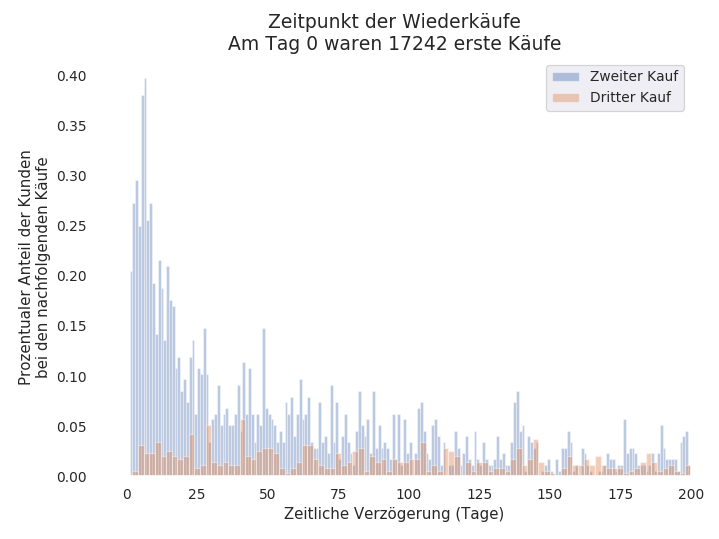

In [98]:
plt.figure(figsize=(8,6))
factor = 1
plt.hist(Secondo.TageDelta_x,bins=int((Secondo.TageDelta_x.max()-Secondo.TageDelta_x.min())/factor),alpha=0.4,label='Zweiter Kauf',\
         weights=np.ones_like(Secondo.TageDelta_x)*100/factor/Primo.TageDelta_x.count())
factor = 2
plt.hist(Terzo.TageDelta_x,bins=int((Terzo.TageDelta_x.max()-Terzo.TageDelta_x.min())/factor),alpha=0.4,label='Dritter Kauf',\
        weights=np.ones_like(Terzo.TageDelta_x)*100/factor/Primo.TageDelta_x.count())
plt.legend()
plt.title('Zeitpunkt der Wiederkäufe\nAm Tag 0 waren '+str((Primo.TageDelta_x==0.0).sum())+' erste Käufe',size=15)
plt.gca().set_facecolor('w')
plt.xlim([-10,200])
plt.xlabel('Zeitliche Verzögerung (Tage)')
plt.ylabel('Prozentualer Anteil der Kunden\nbei den nachfolgenden Käufe')
plt.tight_layout()
#plt.savefig('BunteBilder/'+BU+'/Wiederkaeufe.png')

plt.show()

<IPython.core.display.Javascript object>


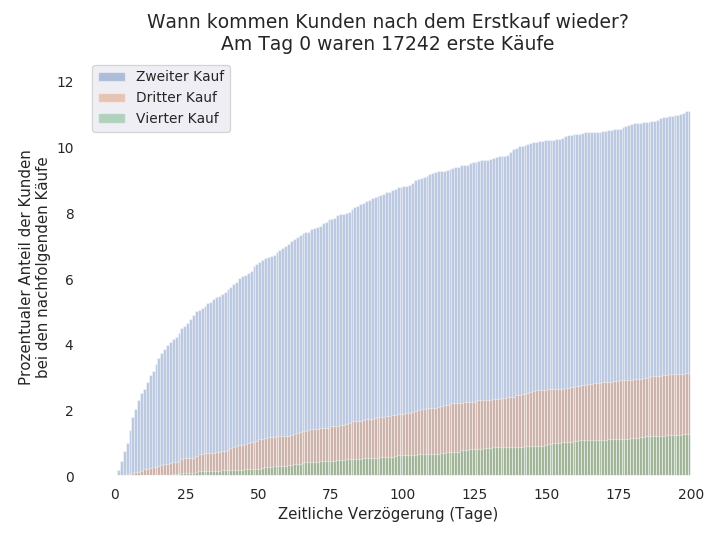

In [99]:
plt.figure(figsize=(8,6))
plt.hist(Secondo.TageDelta_x,bins=int(Secondo.TageDelta_x.max()-Secondo.TageDelta_x.min()),alpha=0.4,label='Zweiter Kauf',\
         cumulative=True,weights=np.ones_like(Secondo.TageDelta_x)*100/Primo.TageDelta_x.count())
plt.hist(Terzo.TageDelta_x,bins=int(Terzo.TageDelta_x.max()-Terzo.TageDelta_x.min()),alpha=0.4,label='Dritter Kauf',\
         cumulative=True,weights=np.ones_like(Terzo.TageDelta_x)*100/Primo.TageDelta_x.count())
plt.hist(Quarto.TageDelta_x,bins=int(Quarto.TageDelta_x.max()-Quarto.TageDelta_x.min()),alpha=0.4,label='Vierter Kauf',\
         cumulative=True,weights=np.ones_like(Quarto.TageDelta_x)*100/Primo.TageDelta_x.count())
plt.legend()
plt.gca().set_facecolor('w')
plt.xlabel('Zeitliche Verzögerung (Tage)')
plt.title('Wann kommen Kunden nach dem Erstkauf wieder?\nAm Tag 0 waren '+str((Primo.TageDelta_x==0.0).sum())+' erste Käufe',size=15)
plt.ylabel('Kumulative Anzahl der Kunden\nbei den nachfolgenden Käufe')
plt.xlim([-10,200])
plt.tight_layout()
plt.ylabel('Prozentualer Anteil der Kunden\nbei den nachfolgenden Käufe')
#plt.savefig('BunteBilder/'+BU+'/KumulativeWiederkaeufe.png')

plt.show()


<IPython.core.display.Javascript object>


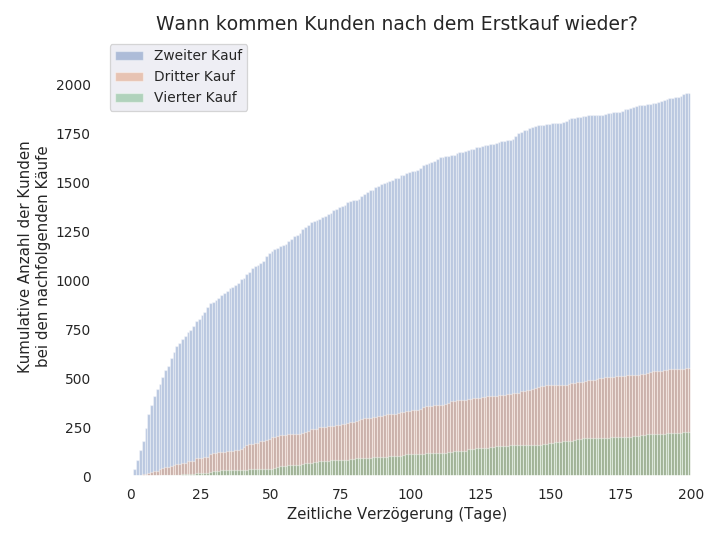

In [100]:
plt.figure(figsize=(8,6))
plt.hist(Secondo.TageDelta_x,bins=int(Secondo.TageDelta_x.max()-Secondo.TageDelta_x.min()),alpha=0.4,label='Zweiter Kauf',cumulative=True)
plt.hist(Terzo.TageDelta_x,bins=int(Terzo.TageDelta_x.max()-Terzo.TageDelta_x.min()),alpha=0.4,label='Dritter Kauf',cumulative=True)
plt.hist(Quarto.TageDelta_x,bins=int(Quarto.TageDelta_x.max()-Quarto.TageDelta_x.min()),alpha=0.4,label='Vierter Kauf',cumulative=True)
plt.legend()
plt.gca().set_facecolor('w')
plt.xlabel('Zeitliche Verzögerung (Tage)')
plt.title('Wann kommen Kunden nach dem Erstkauf wieder?',size=15)
plt.ylabel('Kumulative Anzahl der Kunden\nbei den nachfolgenden Käufe')
plt.xlim([-10,200])
plt.tight_layout()
plt.show()
